In [5]:
import csv
import re
import os

log_dir = "./log_data"
csv_output_path = "./h4_extra.csv"

filename_pattern = r"(\w+)_hot_(\w+)_cold_(\w+)_run(\d+).log"

# 일반 stat 키 (COUNT 기반)
target_keys = [
    # WAF
    'rocksdb.flush.write.bytes',
    'rocksdb.compact.write.bytes',
    'rocksdb.bytes.written',

    # RAF
    'rocksdb.number.keys.read',
    'rocksdb.bytes.read',

    # Cache Hit/Miss
    'rocksdb.block.cache.hit',
    'rocksdb.block.cache.miss',
    "rocksdb.memtable.hit",
    "rocksdb.memtable.miss",

    # Latency metrics (COUNT 전용 처리용)
    'rocksdb.db.get.micros',
    'rocksdb.db.write.micros',
    'rocksdb.db.seek.micros',

    # 시간
    'rocksdb.compaction.total.time.cpu_micros',

    # 압축률
    'rocksdb.bytes.compressed.from',
    'rocksdb.bytes.compressed.to',

    # Write stall 계열
    'rocksdb.db.write.stall',
    'rocksdb.stall.micros',
    'rocksdb.flush.write.bytes',
    'rocksdb.memtable.payload.bytes.at.flush',
    'rocksdb.memtable.garbage.bytes.at.flush',
    'rocksdb.file.read.flush.micros',
    'rocksdb.file.write.flush.micros',
    'rocksdb.db.flush.micros',
]

# Latency metric 패턴을 갖는 항목들
latency_metrics = [
    'db.get.micros',
    'db.write.micros',
    'db.write.stall',
    'file.read.flush.micros',
    'file.write.flush.micros',
    'db.flush.micros'
]

# Latency 헤더 구성
latency_fields = []
for metric in latency_metrics:
    prefix = metric.replace('.', '_')  # CSV 필드로 적합한 이름으로 변경
    latency_fields += [
        f'{prefix}.P50', f'{prefix}.P95', f'{prefix}.P99', f'{prefix}.P100',
        f'{prefix}.COUNT', f'{prefix}.SUM', f'{prefix}.AVG'
    ]

# CSV 헤더
header = [
    'work', 'hot', 'cold', 'trial',
    'time(s)', 'hot_column_key', 'default_column_key'
] + target_keys + latency_fields

rows = []

# Latency 파싱용 정규표현식 딕셔너리
latency_patterns = {
    metric: re.compile(
        rf"rocksdb\.{re.escape(metric)}\s+P50\s*:\s*([\d\.]+)\s+P95\s*:\s*([\d\.]+)"
        r"\s+P99\s*:\s*([\d\.]+)\s+P100\s*:\s*([\d\.]+)\s+COUNT\s*:\s*(\d+)\s+SUM\s*:\s*(\d+)"
    )
    for metric in latency_metrics
}

# 로그 파일 순회
for log_file_name in os.listdir(log_dir):
    if not log_file_name.endswith('.log'):
        continue

    match = re.match(filename_pattern, log_file_name)
    if not match:
        print(f"Filename {log_file_name} does not match the expected pattern.")
        continue

    work, hot, cold, trial = match.groups()

    stats_dict = {key: 0 for key in target_keys}
    latency_dict = {key: 0 for key in latency_fields}
    time_sec = 0
    hot_col_keys = 0
    default_col_keys = 0

    log_file_path = os.path.join(log_dir, log_file_name)

    with open(log_file_path, "r") as f:
        for line in f:
            line = line.strip()

            # 시간 추출
            time_match = re.match(r"총 소요시간: (\d+(?:\.\d+)?)초", line)
            if time_match:
                time_sec = float(time_match.group(1))
                continue

            # 키 수 추출
            hot_match = re.match(r"hot 컬럼에서 찾은 키 수: (\d+)", line)
            if hot_match:
                hot_col_keys = int(hot_match.group(1))
                continue

            default_match = re.match(r"default 컬럼에 저장된 키 수: (\d+)", line)
            if default_match:
                default_col_keys = int(default_match.group(1))
                continue

            # 일반 stat 추출 (COUNT 기반)
            stat_match = re.match(r"(rocksdb\.[\w\.]+)\s+COUNT\s*:\s*(\d+)", line)
            if stat_match:
                key = stat_match.group(1)
                value = int(stat_match.group(2))
                if key in stats_dict:
                    stats_dict[key] = value
                continue

            # Latency metric 파싱
            for metric, pattern in latency_patterns.items():
                match = pattern.match(line)
                if match:
                    p50, p95, p99, p100, count, total = map(float, match.groups())
                    prefix = metric.replace('.', '_')
                    latency_dict.update({
                        f'{prefix}.P50': p50,
                        f'{prefix}.P95': p95,
                        f'{prefix}.P99': p99,
                        f'{prefix}.P100': p100,
                        f'{prefix}.COUNT': int(count),
                        f'{prefix}.SUM': int(total),
                        f'{prefix}.AVG': total / count if count > 0 else 0
                    })
                    break

    # 최종 row 추가
    row = [
        work, hot, cold, trial,
        time_sec, hot_col_keys, default_col_keys
    ] + [stats_dict[key] for key in target_keys] + [latency_dict[key] for key in latency_fields]
    rows.append(row)

# CSV 파일 저장
with open(csv_output_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(header)
    writer.writerows(rows)

print(f"CSV summary saved to {csv_output_path}")


CSV summary saved to ./h4_extra.csv


In [2]:
import pandas as pd

pd.set_option('display.max_columns', None)  # 모든 열 표시
pd.set_option('display.max_rows', None)  # 모든 행 표시

# CSV 파일 읽기
df = pd.read_csv("./h4_extra.csv")


# case 분류 함수
def classify_case(row):
    hot = row.get('hot', '').lower()
    cold = row.get('cold', '').lower()

    if hot == 'snappy' and cold == 'snappy':
        return 0
    elif hot == 'lz4' and cold == 'zlib':
        return 1
    elif hot == 'lz4' and cold == 'zstd':
        return 2
    elif hot == 'none' and cold == 'zlib':
        return 3
    elif hot == 'none' and cold == 'zstd':
        return 4
    elif hot == 'snappy' and cold == 'zlib':
        return 5
    elif hot == 'snappy' and cold == 'zstd':
        return 6
    else:
        return -1  # 알 수 없는 조합 (예외 처리용)
# case 분류
df['case'] = df.apply(classify_case, axis=1)
df

,work,hot,cold,trial,time(s),hot_column_key,default_column_key,rocksdb.flush.write.bytes,rocksdb.compact.write.bytes,rocksdb.bytes.written,rocksdb.number.keys.read,rocksdb.bytes.read,rocksdb.block.cache.hit,rocksdb.block.cache.miss,rocksdb.memtable.hit,rocksdb.memtable.miss,rocksdb.db.get.micros,rocksdb.db.write.micros,rocksdb.db.seek.micros,rocksdb.compaction.total.time.cpu_micros,rocksdb.bytes.compressed.from,rocksdb.bytes.compressed.to,rocksdb.db.write.stall,rocksdb.stall.micros,rocksdb.flush.write.bytes.1,rocksdb.memtable.payload.bytes.at.flush,rocksdb.memtable.garbage.bytes.at.flush,rocksdb.file.read.flush.micros,rocksdb.file.write.flush.micros,rocksdb.db.flush.micros,db_get_micros.P50,db_get_micros.P95,db_get_micros.P99,db_get_micros.P100,db_get_micros.COUNT,db_get_micros.SUM,db_get_micros.AVG,db_write_micros.P50,db_write_micros.P95,db_write_micros.P99,db_write_micros.P100,db_write_micros.COUNT,db_write_micros.SUM,db_write_micros.AVG,db_write_stall.P50,db_write_stall.P95,db_write_stall.P99,db_write_stall.P100,db_write_stall.COUNT,db_write_stall.SUM,db_write_stall.AVG,file_read_flush_micros.P50,file_read_flush_micros.P95,file_read_flush_micros.P99,file_read_flush_micros.P100,file_read_flush_micros.COUNT,file_read_flush_micros.SUM,file_read_flush_micros.AVG,file_write_flush_micros.P50,file_write_flush_micros.P95,file_write_flush_micros.P99,file_write_flush_micros.P100,file_write_flush_micros.COUNT,file_write_flush_micros.SUM,file_write_flush_micros.AVG,db_flush_micros.P50,db_flush_micros.P95,db_flush_micros.P99,db_flush_micros.P100,db_flush_micros.COUNT,db_flush_micros.SUM,db_flush_micros.AVG,case
0,read,LZ4,Zlib,2,24.314,679362,0,0,334523,0,1000000,12659818496,1141503,1696079,0,1000000,0,0,0,0,62018794,313573,0,0,0,0,0,0,0,0,8.688403,92.452930,107.570592,784.0,1000000,23208530,23.208530,0.000000,0.000000,0.000000,0.0,0,0,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0,0,0.000000e+00,0.000000,0.000000,0.000000,0.0,0,0,0.000000,0.000000,0.000000,0.000000,0.0,0,0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0,0,0.000000e+00,1
1,read,Snappy,ZSTD,1,11.830,678638,0,0,853594,0,1000000,12656115712,1192057,1263358,0,1000000,0,0,0,0,61954404,832663,0,0,0,0,0,0,0,0,8.896087,18.084461,21.627374,768.0,1000000,10589710,10.589710,0.000000,0.000000,0.000000,0.0,0,0,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0,0,0.000000e+00,0.000000,0.000000,0.000000,0.0,0,0,0.000000,0.000000,0.000000,0.000000,0.0,0,0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0,0,0.000000e+00,6
2,read,none,ZSTD,2,21.091,678608,0,0,2114885947,0,1000000,12643778560,658150,3730954,0,1000000,0,0,0,1719046,36232737,121925,0,0,0,0,0,0,0,0,16.503120,47.175926,66.397294,1768.0,1000000,19716978,19.716978,0.000000,0.000000,0.000000,0.0,0,0,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0,0,0.000000e+00,0.000000,0.000000,0.000000,0.0,0,0,0.000000,0.000000,0.000000,0.000000,0.0,0,0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0,0,0.000000e+00,4
3,read,Snappy,Snappy,1,20.867,678600,0,0,201724887,0,1000000,12659474432,219891,2672206,0,1000000,0,0,0,2914179,4069768137,200479868,0,0,0,0,0,0,0,0,9.283244,50.832027,71.299575,796.0,1000000,19574484,19.574484,0.000000,0.000000,0.000000,0.0,0,0,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0,0,0.000000e+00,0.000000,0.000000,0.000000,0.0,0,0,0.000000,0.000000,0.000000,0.000000,0.0,0,0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0,0,0.000000e+00,0
4,write,Snappy,Zlib,1,205.980,0,250961,579596782,2630024822,16407310193,1806052,7289389056,8307136,5395064,7755,1798297,0,0,0,104748457,85258050781,3183367964,0,194618038,579596782,16269692701,219414638,0,0,0,2.013612,27.858383,44.965496,1053.0,1806052,14386003,7.965442,8.427429,13.872257,18.192436,3397636.0,1000000,204604063,204.604063,2.101754e+06,2.883333e+06,3397515.0,3397515.0,99,194618038,1.965839e+06,2.222222,19.600000,60.000000,150.0,692,3884,5.612717,0.500434,0.950824,0.990859,3345.0,1958847,317029,0.161845,1.853846e+05,3.720556e+05,6.927667e+05,786133.0,173,35549459,2.

In [6]:
import pandas as pd

# CSV에서 데이터 불러오기
df = pd.read_csv("./h4_extra.csv")

# case 분류 함수
def classify_case(row):
    hot = row.get('hot', '').lower()
    cold = row.get('cold', '').lower()

    if hot == 'snappy' and cold == 'snappy':
        return 0
    elif hot == 'lz4' and cold == 'zlib':
        return 1
    elif hot == 'lz4' and cold == 'zstd':
        return 2
    elif hot == 'none' and cold == 'zlib':
        return 3
    elif hot == 'none' and cold == 'zstd':
        return 4
    elif hot == 'snappy' and cold == 'zlib':
        return 5
    elif hot == 'snappy' and cold == 'zstd':
        return 6
    else:
        return -1  # 알 수 없는 조합 (예외 처리용)

# case 분류
df['case'] = df.apply(classify_case, axis=1)

# 분석 결과 저장할 리스트
analysis_rows = []

for idx, row in df.iterrows():
    # 총 시간
    total_time = row['time(s)']
    
    # compaction 시간
    compaction_time = row.get('rocksdb.compaction.total.time.cpu_micros', 0)

    # stall 및 flush 관련 주요 지표
    stall_micros = row.get('rocksdb.stall.micros', 0)
    write_stall_count = row.get('rocksdb.db.write.stall', 0)
    flush_read_micros = row.get('rocksdb.file.read.flush.micros', 0)
    flush_write_micros = row.get('rocksdb.file.write.flush.micros', 0)
    db_flush_micros = row.get('rocksdb.db.flush.micros', 0)

    # 압축 관련
    compressed_from = row.get('rocksdb.bytes.compressed.from', 0)
    compressed_to = row.get('rocksdb.bytes.compressed.to', 0)

    # write량
    write_bytes = row.get('rocksdb.bytes.written', 0)
    flush_bytes = row.get('rocksdb.flush.write.bytes', 0)
    compact_bytes = row.get('rocksdb.compact.write.bytes', 0)

    # 비율 계산
    compaction_ratio = compaction_time / total_time if total_time > 0 else 0
    stall_flush_total = stall_micros + flush_read_micros + flush_write_micros + db_flush_micros

    # 판단 기준
    compaction_is_low = compaction_ratio < 0.05  # 전체 시간 대비 5% 이하
    stall_flush_high = stall_flush_total > 1e6 or write_stall_count > 0  # 1초 이상 stall/flush이거나 write_stall 존재

    reason = ""
    if stall_flush_high and compaction_is_low:
        reason = (
            "Total time increased due to stall/flush, "
            "but compaction time remained low. "
            "This may indicate write stalls or flush bottlenecks reduced compaction work "
            "(e.g., fewer SSTs generated or low write pressure)."
        )
    elif compaction_is_low:
        reason = "Compaction was low, possibly due to low write or flush volume."
    elif stall_flush_high:
        reason = "High stall/flush impact detected, possibly causing total time inflation."

    analysis_rows.append({
        "work": row["work"],
        "hot": row["hot"],
        "cold": row["cold"],
        "trial": row["trial"],
        "total_time(s)": total_time,
        "compaction_time(us)": compaction_time,
        "compaction_ratio": round(compaction_ratio, 4),
        "stall_flush_total(us)": stall_flush_total,
        "write_stall_count": write_stall_count,
        "compressed_from": compressed_from,
        "compressed_to": compressed_to,
        "flush_bytes": flush_bytes,
        "compact_bytes": compact_bytes,
        "reason": reason,
        "case": row["case"]
    })

# 분석 결과 DataFrame 생성 및 출력
analysis_df = pd.DataFrame(analysis_rows)
print(analysis_df[["work", "hot", "cold", "trial", "compaction_ratio", "stall_flush_total(us)", "reason"]])

# CSV로 저장할 수도 있음
analysis_df.to_csv("analysis_result.csv", index=False)
print("Analysis saved to analysis_result.csv")


     work     hot    cold  trial  compaction_ratio  stall_flush_total(us)  \
0    read     LZ4    Zlib      2            0.0000                      0   
1    read  Snappy    ZSTD      1            0.0000                      0   
2    read    none    ZSTD      2        81506.1401                      0   
3    read  Snappy  Snappy      1       139654.9097                      0   
4   write  Snappy    Zlib      1       508537.0279              194618038   
5   write  Snappy    Zlib      3       435675.8678              239780213   
6   write  Snappy    Zlib      2       511211.5379              175258057   
7   write  Snappy    ZSTD      3       250741.2854              215012528   
8    read  Snappy  Snappy      2            0.0000                      0   
9    read  Snappy    Zlib      1            0.0000                      0   
10  write    none    ZSTD      1        55388.5765              641343197   
11   read     LZ4    ZSTD      2            0.0000                      0   

In [11]:
analysis_write = analysis_df[analysis_df['work'] == 'write'].groupby('case').mean(numeric_only=True)
analysis_write

,trial,total_time(s),compaction_time(us),compaction_ratio,stall_flush_total(us),write_stall_count,compressed_from,compressed_to,flush_bytes,compact_bytes
case,,,,,,,,,,
0,2.0,243.920333,5.732423e+07,236412.894633,2.312757e+08,0.0,9.314952e+10,4.592171e+09,8.039193e+08,3.816924e+09
1,2.0,212.126333,9.631008e+07,473700.154967,1.971947e+08,0.0,8.853679e+10,5.205898e+08,1.014797e+08,4.463376e+08
2,2.0,248.571333,4.220473e+07,174114.522400,2.355379e+08,0.0,9.397209e+10,5.427967e+08,9.780132e+07,4.738812e+08
3,2.0,638.434333,7.451153e+07,120212.578767,6.118331e+08,0.0,1.692666e+10,6.800734e+07,1.129535e+10,2.870579e+10
4,2.0,564.752333,3.837740e+07,69441.745733,5.416918e+08,0.0,1.847747e+10,6.058077e+07,1.129219e+10,2.887628e+10
5,2.0,214.903000,1.033478e+08,485141.477867,2.032188e+08,0.0,8.599068e+10,3.242044e+09,5.817105e+08,2.686812e+09
6,2.0,209.190667,5.682852e+07,273957.249600,1.958713e+08,0.0,9.566903e+10,3.614035e+09,5.790198e+08,3.064453e+09


In [12]:
analysis_read = analysis_df[analysis_df['work'] == 'read'].groupby('case').mean(numeric_only=True)
analysis_read

,trial,total_time(s),compaction_time(us),compaction_ratio,stall_flush_total(us),write_stall_count,compressed_from,compressed_to,flush_bytes,compact_bytes
case,,,,,,,,,,
0,2.0,19.564333,9.713930e+05,46551.636567,0.0,0.0,1.397960e+09,6.887504e+07,0.0,6.930403e+07
1,2.0,32.483667,0.000000e+00,0.000000,0.0,0.0,6.201340e+07,3.104347e+05,0.0,3.313823e+05
2,2.0,14.532667,0.000000e+00,0.000000,0.0,0.0,6.200255e+07,2.706947e+05,0.0,2.916390e+05
3,2.0,41.910000,9.093724e+06,227218.287767,0.0,0.0,1.774193e+09,6.788665e+06,0.0,2.849234e+09
4,2.0,21.397667,1.650667e+06,77345.449167,0.0,0.0,4.360764e+07,1.467080e+05,0.0,1.972386e+09
5,2.0,33.466333,1.300067e+05,3523.693367,0.0,0.0,1.199037e+08,1.969933e+06,0.0,2.008860e+06
6,2.0,13.962000,0.000000e+00,0.000000,0.0,0.0,6.200919e+07,8.613637e+05,0.0,8.823120e+05


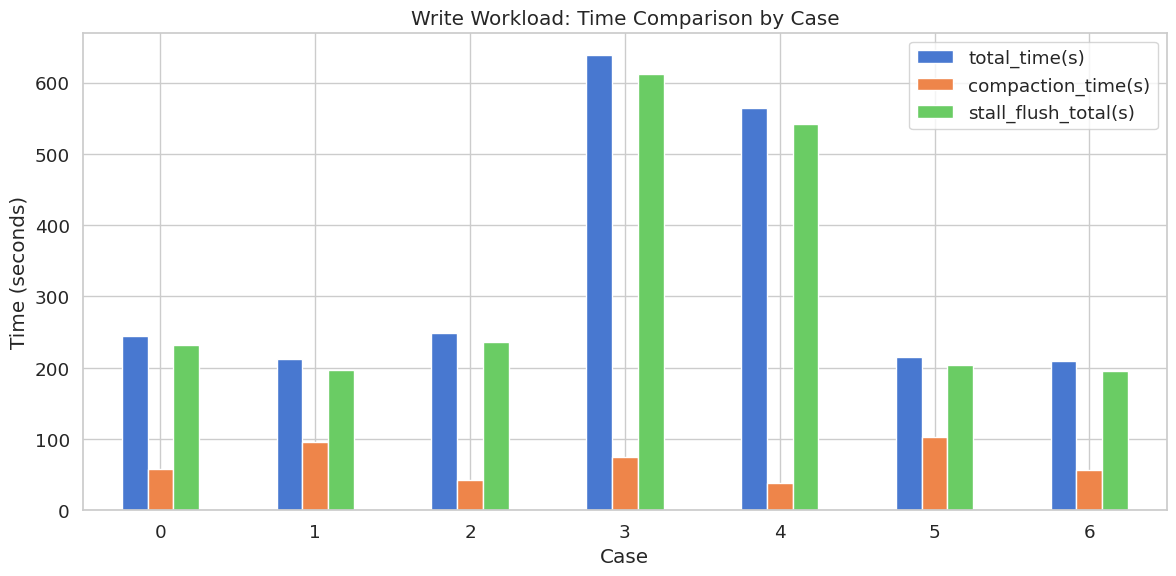

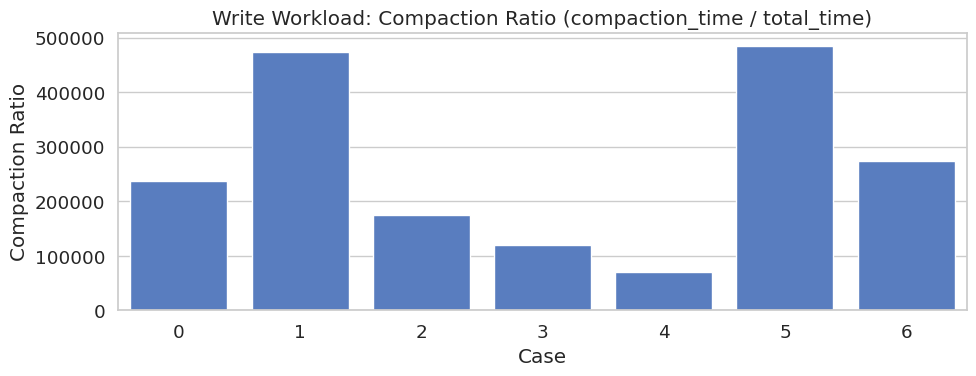

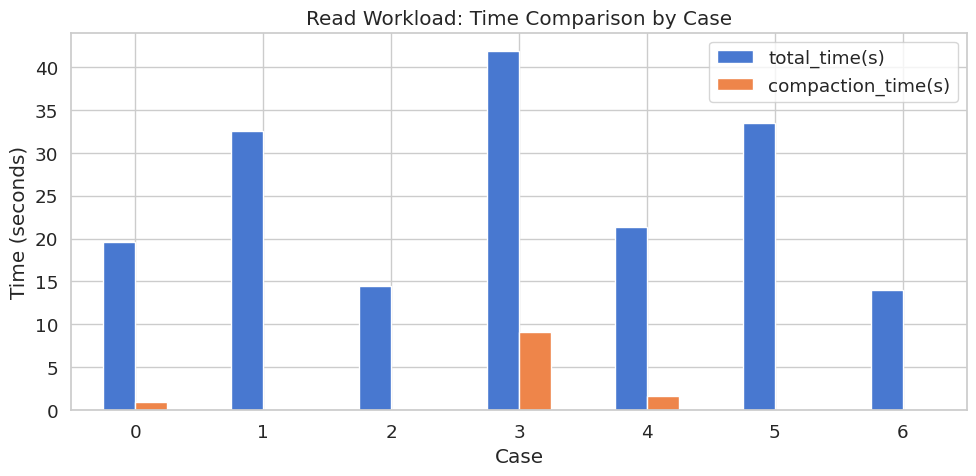

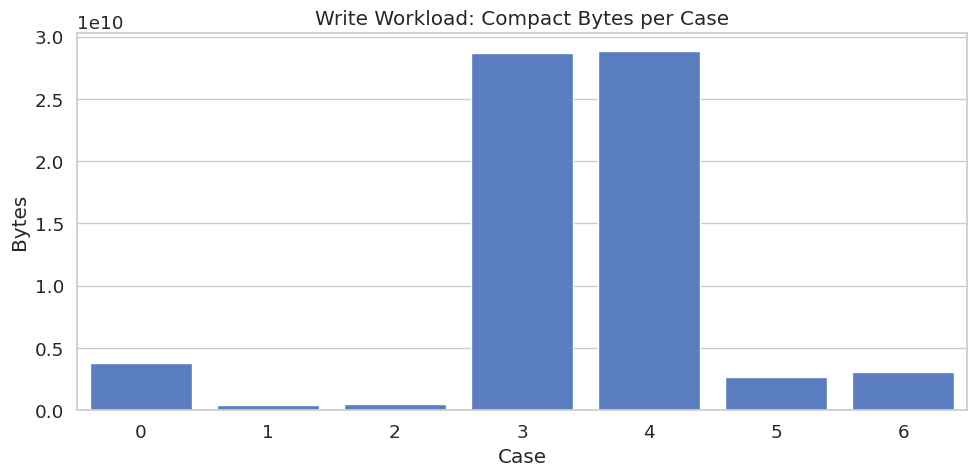

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set visualization style
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# DataFrames: analysis_write, analysis_read are assumed to be pre-defined

# 1. Compare time-related metrics in write workloads
fig, ax = plt.subplots(figsize=(12, 6))
analysis_write_plot = analysis_write[['total_time(s)', 
                                      'compaction_time(us)', 
                                      'stall_flush_total(us)']].copy()

# Convert microseconds to seconds
analysis_write_plot['compaction_time(s)'] = analysis_write_plot['compaction_time(us)'] / 1e6
analysis_write_plot['stall_flush_total(s)'] = analysis_write_plot['stall_flush_total(us)'] / 1e6
analysis_write_plot = analysis_write_plot.drop(columns=['compaction_time(us)', 'stall_flush_total(us)'])

analysis_write_plot.plot(kind='bar', ax=ax)
ax.set_title("Write Workload: Time Comparison by Case")
ax.set_ylabel("Time (seconds)")
ax.set_xlabel("Case")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 2. Visualize compaction ratio in write workloads
plt.figure(figsize=(10, 4))
sns.barplot(data=analysis_write.reset_index(), x='case', y='compaction_ratio')
plt.title("Write Workload: Compaction Ratio (compaction_time / total_time)")
plt.ylabel("Compaction Ratio")
plt.xlabel("Case")
plt.tight_layout()
plt.show()

# 3. Compare total_time and compaction_time in read workloads
fig, ax = plt.subplots(figsize=(10, 5))
analysis_read_plot = analysis_read[['total_time(s)', 'compaction_time(us)']].copy()
analysis_read_plot['compaction_time(s)'] = analysis_read_plot['compaction_time(us)'] / 1e6
analysis_read_plot = analysis_read_plot.drop(columns=['compaction_time(us)'])

analysis_read_plot.plot(kind='bar', ax=ax)
ax.set_title("Read Workload: Time Comparison by Case")
ax.set_ylabel("Time (seconds)")
ax.set_xlabel("Case")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 4. Compact bytes per case in write workloads
plt.figure(figsize=(10, 5))
sns.barplot(data=analysis_write.reset_index(), x='case', y='compact_bytes')
plt.title("Write Workload: Compact Bytes per Case")
plt.ylabel("Bytes")
plt.xlabel("Case")
plt.tight_layout()
plt.show()
